# Poisson Regression

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson as pois
import time
from copy import deepcopy
import pandas as pd
from sklearn.model_selection import train_test_split as split

In [2]:
def f_poisson(T,a,b):
    '''
    T is the weight vector in R^n, a is the regressor matrix in R^{n x m}, b is the count data in R^m
    '''
    u = a @ T
    return np.sum(np.exp(u)) - np.dot(y,u)
def g_poisson(T,a,b):
    '''
    T is the weight vector in R^n, a is the regressor matrix in R^{n x m}, b is the count data in R^m
    '''
    u = np.exp( a @ T )
    return a.T @ u - np.dot(b,a)
def GD_poisson(T,grad,LAMBDA):
    '''Perform Steepest Gradient Descent'''
    return T - LAMBDA*grad
def ren(x): return range(len(x))
rng = np.random.default_rng()

In [3]:
N = 10
M = 20000

In [4]:
omega = rng.random(N +1)
X = rng.random((M,N))
x = np.concatenate((np.ones((M,1)),X),axis = 1)
lamb = np.dot(x , omega)
y = np.array([pois.rvs(i) for i in lamb])
th = rng.random(len(x[0]))

In [5]:
x

array([[1.        , 0.72879656, 0.95175041, ..., 0.43525171, 0.25782171,
        0.66991148],
       [1.        , 0.89340416, 0.09532189, ..., 0.52795795, 0.90785946,
        0.28168775],
       [1.        , 0.59196596, 0.06200892, ..., 0.90817232, 0.37199104,
        0.47898041],
       ...,
       [1.        , 0.9782037 , 0.75102402, ..., 0.79557208, 0.21564624,
        0.75753386],
       [1.        , 0.27507729, 0.36205436, ..., 0.55296028, 0.36948171,
        0.56974867],
       [1.        , 0.24287627, 0.50684399, ..., 0.78153578, 0.68735677,
        0.86370791]])

In [6]:
np.shape(x.T@x)

(11, 11)

## Vanilla

In [7]:
ERROR = 1e-6

In [8]:
1/np.max( np.linalg.svd( x.T@x )[1] )

1.4051136559828668e-05

In [9]:
initialTime = time.time()
weights = deepcopy(th)
# lam = 1
lam = 1/np.max( np.linalg.svd( x.T @ x )[1] )
lamListVan = []
grad = g_poisson(weights,x,y)
gradNorm = np.linalg.norm(grad)
# print(gradNorm)
gradientValueList = [gradNorm]
functionVals = [f_poisson(weights,x,y)]
timeList = [time.time() - initialTime]
while gradNorm > ERROR:
    lamListVan.append(lam)
    weights = GD_poisson(weights,grad,lam)
    grad = g_poisson(weights,x,y)
    gradNorm = np.linalg.norm(grad)
#     print(gradNorm)
    gradientValueList.append(gradNorm)
    functionVals.append(f_poisson(weights,x,y))
    timeList.append(time.time()-initialTime)
    if gradientValueList[-1] >= gradientValueList[-2]:
        print('ping! Iteration:', len(gradientValueList))
        weights = deepcopy(th)
        lam = 0.1*lam
        grad = g_poisson(weights,x,y)
        gradNorm = np.linalg.norm(grad)
        gradientValueList.append(gradNorm)
        functionVals.append(f_poisson(weights,x,y))
        timeList.append(time.time()-initialTime)

ping! Iteration: 10


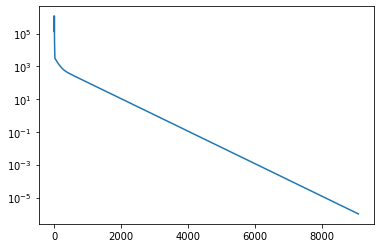

In [10]:
plt.plot(ren(gradientValueList), gradientValueList)
plt.yscale('log')
plt.show()

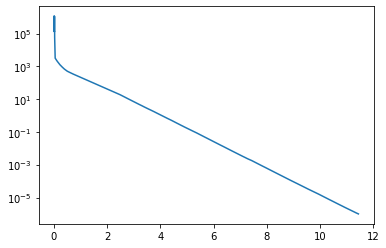

In [11]:
plt.plot(timeList, gradientValueList)
plt.yscale('log')
plt.show()

In [12]:
lam

1.405113655982867e-06

## Adaptive

In [13]:
initialTime = time.time()
weights = deepcopy(th)
lam = 1/np.max(np.linalg.svd(x.T @ x)[1]*M*N)
lamListAdap = [lam]
theta = np.inf
weights0 = deepcopy(weights)
grad = g_poisson(weights,x,y)
gradNorm = np.linalg.norm(grad)
gradientValueList = [gradNorm]
functionVals = [f_poisson(weights,x,y)]
timeList = [time.time() - initialTime]

weights = GD_poisson(weights,grad,lam)
oldGrad = deepcopy(grad)
grad = g_poisson(weights,x,y)
gradNorm = np.linalg.norm(grad)
gradientValueList.append(gradNorm)
functionVals.append(f_poisson(weights,x,y))
timeList.append(time.time()-initialTime)
while gradNorm > ERROR:
    lam0 = deepcopy(lam)
    min1 = np.sqrt(1 + theta)*lam
    min2_nom = np.linalg.norm(weights - weights0)
    min2_denom = 2*np.linalg.norm(grad - oldGrad)
    lam = np.min([min1, (min2_nom/min2_denom)])
    lamListAdap.append(lam)
    weights0 = deepcopy(weights)
    weights = GD_poisson(weights,grad,lam)
    theta = lam/lam0
    oldGrad = grad
    grad = g_poisson(weights,x,y)
    gradNorm = np.linalg.norm(grad)
    gradientValueList.append(gradNorm)
    functionVals.append(f_poisson(weights,x,y))
    timeList.append(time.time()-initialTime)

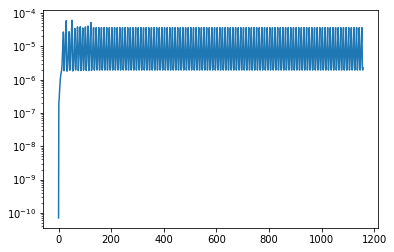

In [14]:
plt.plot(ren(lamListAdap), lamListAdap)
plt.yscale('log')
plt.show()

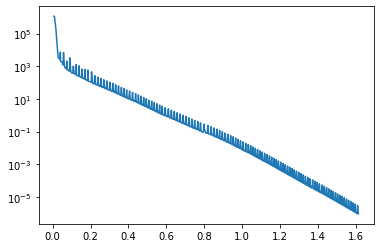

In [15]:
plt.plot(timeList, gradientValueList)
plt.yscale('log')
plt.show()

In [16]:
lam

2.312763178328537e-06

## Gradient-Based Line Search

In [17]:
rho = rng.random()
rng.uniform(rho,10)

6.6970806452126075

In [18]:
def BackTrack(GRAD, GRADNORM, W, X,Y):
    rho = rng.random()
    LAM = rng.random()*10
    while 1 > (GRADNORM/np.linalg.norm( g_poisson(W - LAM*GRAD, X, Y) - GRAD ) ):
        LAM = rho*LAM
    return LAM
initialTime = time.time()
weights = deepcopy(th)
grad = g_poisson(weights,x,y)
gradNorm = np.linalg.norm(grad)
lam = BackTrack(grad, gradNorm, weights, x, y)
lamListLS = [lam]
gradientValueList = [gradNorm]
functionVals = [f_poisson(weights,x,y)]
timeList = [time.time() - initialTime]
while gradNorm > ERROR:
    weights = GD_poisson(weights,grad,lam)
    grad = g_poisson(weights,x,y)
    gradNorm = np.linalg.norm(grad)
    lam = BackTrack(grad, gradNorm, weights, x, y)
    lamListLS.append(lam)
    gradientValueList.append(gradNorm)
    functionVals.append(f_poisson(weights,x,y))
    timeList.append(time.time()-initialTime)

<ipython-input-2-9594c21dce5e>:11: RuntimeWarning: overflow encountered in exp
  u = np.exp( a @ T )


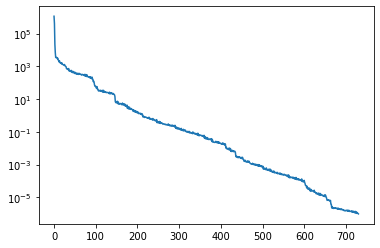

In [19]:
plt.plot(ren(gradientValueList), gradientValueList)
plt.yscale('log')
plt.show()

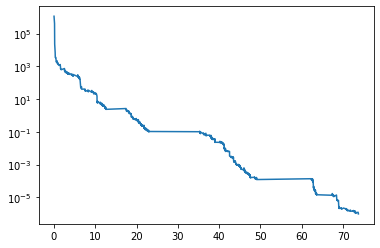

In [20]:
plt.plot(timeList, gradientValueList)
plt.yscale('log')
plt.show()

In [21]:
lam

1.2281039675317742e-05

## Barzilai-Borwein

In [22]:
initialTime = time.time()
weights = deepcopy(th)
lam = 1/np.max(np.linalg.svd(x.T @ x)[1]*M*N)
lamList = [lam]
weights0 = deepcopy(weights)
grad = g_poisson(weights,x,y)
gradNorm = np.linalg.norm(grad)
gradientValueList = [gradNorm]
functionVals = [f_poisson(weights,x,y)]
timeList = [time.time() - initialTime]

weights = GD_poisson(weights,grad,lam)
oldGrad = deepcopy(grad)
grad = g_poisson(weights,x,y)
gradNorm = np.linalg.norm(grad)
gradientValueList.append(gradNorm)
functionVals.append(f_poisson(weights,x,y))
timeList.append(time.time()-initialTime)
while gradNorm > ERROR:
    nom = np.dot(weights - weights0, grad - oldGrad)
    denom = np.linalg.norm(grad - oldGrad)**2
    lam = nom/denom
    lamList.append(lam)
    weights0 = deepcopy(weights)
    weights = GD_poisson(weights,grad,lam)
    oldGrad = deepcopy(grad)
    grad = g_poisson(weights,x,y)
    gradNorm = np.linalg.norm(grad)
    gradientValueList.append(gradNorm)
    functionVals.append(f_poisson(weights,x,y))
    timeList.append(time.time()-initialTime)

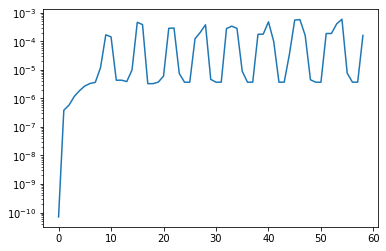

In [23]:
plt.plot(ren(lamList), lamList)
plt.yscale('log')
plt.show()

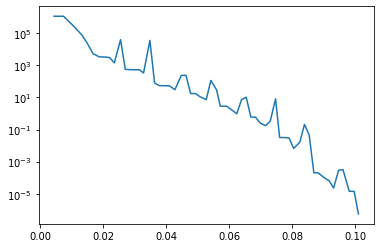

In [24]:
plt.plot(timeList, gradientValueList)
plt.yscale('log')
plt.show()

In [25]:
lam

0.00016158285601458144

## Nesterov

In [26]:
initialTime = time.time()
weights = deepcopy(th)
L = np.max( np.linalg.svd( x.T @ x )[1] )
# L = 10
grad = g_poisson(weights,x,y)
gradNorm = np.linalg.norm(grad)
# print(gradNorm)
gradientValueList = [gradNorm]
functionVals = [f_poisson(weights,x,y)]
timeList = [time.time() - initialTime]
lam1 = 1
y0 = weights
while gradNorm > ERROR:
    lam = 0.5*(1 + np.sqrt(1 + 4*lam1**2))
    gamma = (1 - lam1)/lam
    y1 = weights - grad/L
    weights = (1 - gamma)*y1 + gamma*y0
    lam1 = lam
    y0 = y1
    grad = g_poisson(weights,x,y)
    gradNorm = np.linalg.norm(grad)
#     print(gradNorm)
    gradientValueList.append(gradNorm)
    functionVals.append(f_poisson(weights,x,y))
    timeList.append(time.time()-initialTime)
    if gradientValueList[-1] == gradientValueList[-2]:
        print('ping! Iteration:', len(gradientValueList))
        weights = deepcopy(th)
        L = L*10
        grad = g_poisson(weights,x,y)
        gradNorm = np.linalg.norm(grad)
        gradientValueList.append(gradNorm)
        functionVals.append(f_poisson(weights,x,y))
        timeList.append(time.time()-initialTime)
        lam1 = 1
        y0 = weights

ping! Iteration: 9


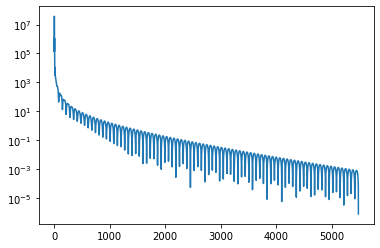

In [27]:
plt.plot(ren(gradientValueList), gradientValueList)
plt.yscale('log')
plt.show()

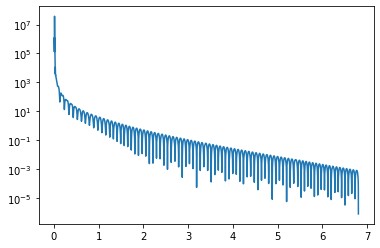

In [28]:
plt.plot(timeList, gradientValueList)
plt.yscale('log')
plt.show()

In [29]:
1/L

1.4051136559828667e-06

Step Size Comparison

In [30]:
gamList

NameError: name 'gamList' is not defined

In [ ]:
plt.plot(ren(lamList[1:]), lamList[1:], label = 'Barzalai Step Size')
plt.plot(ren(lamList[1:]), lamListAdap[1:len(lamList)], c= 'r', label = 'Adaptive Step Size')
plt.plot(ren(lamList[1:]), lamListVan[1:len(lamList)], c= 'y', label = 'Vanilla Step Size')
plt.plot(ren(lamList[1:]), lamListLS[1:len(lamList)], c= 'g', label = 'Line Search Step Size')
plt.plot(ren(lamList[1:]), gamList[1:len(lamList)], c= 'm', label = 'Nesterov Step Size')
plt.yscale('log')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
import plotly.express as px

In [ ]:
Steps = pd.DataFrame(dict(
    baz = lamList,
    adap = lamListAdap,
    ls = lamListLS,
    van = lamListVan
))

In [ ]:
fig = px.line(pd.DataFrame({'x' :ren(lamList),'y':lamList}), x='x', y='y', log_y = True)
fig.show()